In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import next_fast_len

from obspy import Trace, Stream, UTCDateTime
import obsplus
from obsplus.utils.time import to_utc

from mopy import StatsGroup, TraceGroup, SpectrumGroup
from mopy.testing import gauss, gauss_deriv, gauss_deriv_deriv

## Mock up the data structures in the laziest possible way

### Random stuff to make my hack work

In [2]:
ds = obsplus.load_dataset("coal_node")
# Load up some events
cat = ds.event_client.get_events()
# Load up a station inventory
inv = ds.station_client.get_stations()
# Generate a StatsGroup that can be used to create another StatsGroup
sg = StatsGroup(catalog=cat, inventory=inv)

/home/shawn/anaconda3/lib/python3.8/site-packages/obspy/taup/taup_geo.py:110: UserWarning: Assuming spherical planet when calculating epicentral distance. Install the Python module 'geographiclib' to solve this.
  warnings.warn(msg)


### Spawn a StatsGroup from the mocked StatsGroup

In [3]:
# Constants for gauss wave
_t1, _t2, _dt = 0, 10.23, 0.01
_a, _b, _c = 0.1, 5, np.sqrt(2)
_t = np.arange(_t1, _t2, _dt)

In [4]:
# Two streams, one has the full data, the other has only part of it
# (to see the effects of zero padding the data)
df_contents = {
    "event_id": ["event1", "event1"],
    "seed_id": ["UK.STA1..HHZ", "UK.STA2..HHZ"],
    "seed_id_less": ["UK.STA1..HH", "UK.STA2..HH"],
    "phase_hint": ["P", "P"],
    "time": [np.datetime64("2020-01-01T00:00:01"), np.datetime64("2020-01-01T00:00:01")],
    "starttime": [np.datetime64("2020-01-01T00:00:00"), np.datetime64("2020-01-01T00:00:00"),],
    "endtime": [np.datetime64("2020-01-01T00:00:00") + np.timedelta64(int(_t2*1000), 'ms') - np.timedelta64(int(_dt*1000), 'ms'), 
                np.datetime64("2020-01-01T00:00:00") + np.timedelta64(int(_t2//2*1000), 'ms') - np.timedelta64(int(_dt*1000), 'ms'),],
    "ray_path_length_m": [2000, 2000],
    "hyp_distance_m": [2000, 2000],
}
df = pd.DataFrame(df_contents, columns=df_contents.keys())
df.set_index(['phase_hint', 'event_id', 'seed_id_less', 'seed_id'], inplace=True)
df["sampling_rate"] = 1/_dt
sg = sg.new_from_dict(data=df)  # This is a weird way to do this

### Create a TraceGroup

In [5]:
# Generate the data
data = gauss(_t, _a, _b, _c)
# Build a stream from the data
tr = Trace(data=data, header={
    "starttime": to_utc(sg.data.iloc[0].starttime),
    "delta": _dt,
    "network": "UK",
    "station": "STA1",
    "channel": "HHZ",
})
st = Stream()
st.append(tr)
# Add a second trace with a substantial discontinuity caused by zero-padding
st.append(tr.copy())  # Same data, but the time window in the StatsGroup halves it
st[1].stats.station = "STA2"
# Make a TraceGroup
tg = TraceGroup(sg, st, "displacement").fillna()
tg_v = TraceGroup(sg, st.copy().differentiate(), "velocity").fillna()

[  1.57783680e+09   1.57783680e+09]
[  1.57783681e+09   1.57783680e+09]
phase_hint  event_id  seed_id_less  seed_id     
P           event1    UK.STA1..HH   UK.STA1..HHZ    1.577837e+09
                      UK.STA2..HH   UK.STA2..HHZ    1.577837e+09
Name: starttime, dtype: float64
phase_hint  event_id  seed_id_less  seed_id     
P           event1    UK.STA1..HH   UK.STA1..HHZ    1.577837e+09
                      UK.STA2..HH   UK.STA2..HHZ    1.577837e+09
Name: endtime, dtype: float64
phase_hint  event_id  seed_id_less  seed_id     
P           event1    UK.STA1..HH   UK.STA1..HHZ    0.0
                      UK.STA2..HH   UK.STA2..HHZ    0.0
Name: starttime, dtype: float64
phase_hint  event_id  seed_id_less  seed_id     
P           event1    UK.STA1..HH   UK.STA1..HHZ    0.0
                      UK.STA2..HH   UK.STA2..HHZ    0.0
Name: endtime, dtype: float64
[  1.57783680e+09   1.57783680e+09]
[  1.57783681e+09   1.57783680e+09]
phase_hint  event_id  seed_id_less  seed_id     
P  

### Create a SpectrumGroup

In [6]:
spec = tg.dft()
spec_v = tg_v.dft()

/media/data/gits/mopy/mopy/core/spectrumgroup.py:45: UserWarning: MoPy specific parameters have not been applied to the StatsGroup. Applying default parameters
  warnings.warn(
/media/data/gits/mopy/mopy/core/spectrumgroup.py:45: UserWarning: MoPy specific parameters have not been applied to the StatsGroup. Applying default parameters
  warnings.warn(


## Convert the displacement data to velocity data

In [7]:
# Time domain
trace0_td = np.gradient(tg.data.iloc[0], _dt)
trace1_td = np.gradient(tg.data.iloc[1], _dt)

In [8]:
# Frequency domain
freqs = spec.data.columns
spec0_fd = 1j * 2 * np.pi * np.array(freqs) * spec.data.iloc[0]  # It bothers me that this isn't an exact match, but instead looks like the zero-padded example in other notebooks...
spec1_fd = 1j * 2 * np.pi * np.array(freqs) * spec.data.iloc[1]

## Convert the spectra to velocity

In [9]:
spec_converted = spec.to_motion_type("velocity")

## Lastly, convert back to the time domain to make sure it didn't dramatically change the data

In [10]:
td = np.fft.irfft(spec_converted.data, axis=-1)

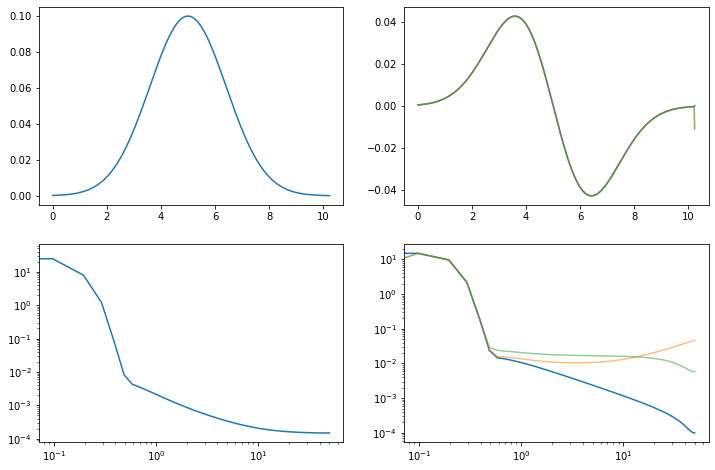

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
ax1.plot(tg.data.columns, tg.data.iloc[0])
ax2.plot(tg_v.data.columns, tg_v.data.iloc[0])
ax2.plot(tg.data.columns, trace0_td, alpha=0.5)
ax2.plot(tg.data.columns, td[0], alpha=0.5)
ax3.loglog(spec.data.columns, abs(spec.data.iloc[0]))
ax4.loglog(spec_v.data.columns, abs(spec_v.data.iloc[0]))
ax4.loglog(freqs, abs(spec0_fd), alpha=0.5)
ax4.loglog(spec_converted.data.columns, abs(spec_converted.data.iloc[0]), alpha=0.5)

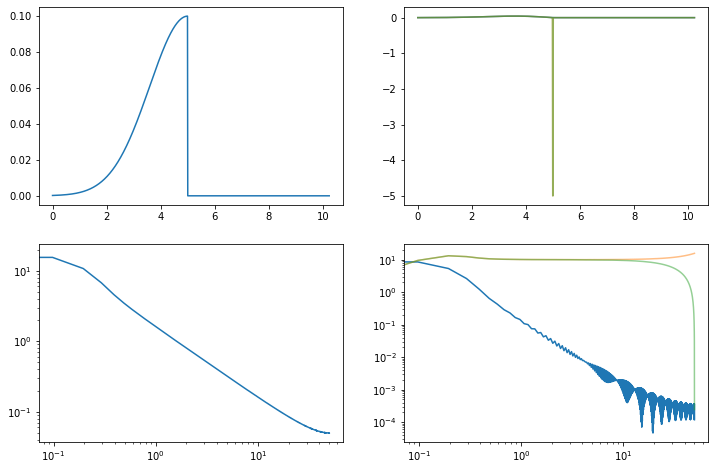

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
ax1.plot(tg.data.columns, tg.data.iloc[1])
ax2.plot(tg_v.data.columns, tg_v.data.iloc[1])
ax2.plot(tg.data.columns, trace1_td, alpha=0.5)
ax2.plot(tg.data.columns, td[1], alpha=0.5)
ax3.loglog(spec.data.columns, abs(spec.data.iloc[1]))
ax4.loglog(spec_v.data.columns, abs(spec_v.data.iloc[1]))
ax4.loglog(freqs, abs(spec1_fd), alpha=0.5)
ax4.loglog(spec_converted.data.columns, abs(spec_converted.data.iloc[1]), alpha=0.5)